<a href="https://colab.research.google.com/github/mizzmir/NLP/blob/machine_translation_develop/machine%20translation%20projects/Seq2Seq/Seq2SeqColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow-gpu --quiet

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 52.9MB/s 
     |████████████████████████████████| 3.8MB 46.1MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.


In [2]:
!git clone https://github.com/mizzmir/data.git

Cloning into 'data'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 14 (delta 2), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [0]:
import os
import re
import sys
import unicodedata
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def normalize(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?-]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def read_data(data_dir, file_name):
    full_path = os.path.join(data_dir, file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      lines = file.readlines()
    
    data = []

    for line in lines:
        data.append(line.split("\t")[:-1])
    
    return data

def read_data_files(data_dir, file_names):
    
    en_file_name, fr_file_name = file_names
    
    full_path = os.path.join(data_dir, en_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      en_lines = file.readlines()
    
    full_path = os.path.join(data_dir, fr_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      fr_lines = file.readlines()    
    
    return en_lines, fr_lines



In [8]:
data_dir = "/content/data"
en_lines, fr_lines = read_data_files(data_dir, ("small_vocab_en", "small_vocab_fr"))

#data = read_data(os.path.join(data_dir, "fra-eng"), "fra.txt")

#en_lines, fr_lines = list(zip(*data))
en_lines, fr_lines = shuffle(en_lines, fr_lines)

#en_lines = en_lines[:40000]
#fr_lines = fr_lines[:40000]

en_lines = [normalize(line) for line in en_lines]
fr_lines = [normalize(line) for line in fr_lines]

en_train, en_test, fr_train, fr_test = train_test_split(en_lines, fr_lines, shuffle=True, test_size=0.1)

en_lines = en_test
fr_lines = fr_test

# creating tokenizers
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en for en in en_train), target_vocab_size=2**13)

fr_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (fr for fr in fr_train), target_vocab_size=2**13)

print("en_tokenizer size ", en_tokenizer.vocab_size)
print("fr_tokenizer size ", fr_tokenizer.vocab_size)

en_tokenizer.save_to_file("en_tokenizer")
fr_tokenizer.save_to_file("fr_tokenizer")

# train dataset
fr_train_in = [[fr_tokenizer.vocab_size] + fr_tokenizer.encode(line) for line in fr_train]
fr_train_out = [fr_tokenizer.encode(line) + [fr_tokenizer.vocab_size+1] for line in fr_train]

fr_train_in = pad_sequences(fr_train_in, padding='post')
fr_train_out = pad_sequences(fr_train_out, padding='post')

# test dataset
fr_test_in = [[fr_tokenizer.vocab_size] + fr_tokenizer.encode(line) for line in fr_test]
fr_test_out = [fr_tokenizer.encode(line) + [fr_tokenizer.vocab_size+1] for line in fr_test]

fr_test_in = pad_sequences(fr_test_in, padding='post')
fr_test_out = pad_sequences(fr_test_out, padding='post')

en_train = [en_tokenizer.encode(line) for line in en_train]
en_test = [en_tokenizer.encode(line) for line in en_test]

en_train = pad_sequences(en_train, padding='post')
en_test = pad_sequences(en_test, padding='post')

reading data from  /content/data/small_vocab_en
reading data from  /content/data/small_vocab_fr
en_tokenizer size  542
fr_tokenizer size  712


In [0]:
# Encoder Decoder network

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, units):
    super(Encoder, self).__init__()

    self.units = units
    self.embeding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size, mask_zero=True, trainable=True)
    self.lstm_layer = tf.keras.layers.LSTM(units, dropout=0.2, return_sequences=True, return_state=True)
  
  def call(self, sequences, lstm_states, training_mode):
    # sequences shape = [batch_size, seq_max_len]
    # lstm_states = [batch_size, lstm_size] x 2
    # encoder_embedded shape = [batch_size, seq_max_len, embedding_size]
    # output shape = [batch_size, seq_max_len, lstm_size]
    # state_h, state_c shape = [batch_size, lstm_size] x 2

    encoder_embedded = self.embeding_layer(sequences, training=training_mode)
    #print("encoder_embedded = ", encoder_embedded.shape)
    output, state_h, state_c = self.lstm_layer(encoder_embedded, initial_state=lstm_states, training=training_mode)

    return output, state_h, state_c

  def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.units]),
                tf.zeros([batch_size, self.units]))

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, units):
    super(Decoder, self).__init__()

    self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size)
    self.lstm_layer = tf.keras.layers.LSTM(units, dropout=0.2, return_sequences=True,
                                           return_state=True)
    self.dense_layer = tf.keras.layers.Dense(vocab_size)
  
  def call(self, sequences, lstm_states, training_mode):
    # sequences shape = [batch_size, seq_max_len]
    # embedding shape = [batch_size, seq_max_len, embedding_size]
    # output shape = [batch_szie, seq_max_len, lstm_size]
    # state_h, state_c = [batch_size, lstm_size] x2
    # dense shape = [batch_size, seq_max_len, vocab_size]
    
    decoder_embedded = self.embedding_layer(sequences, training=training_mode)
    lstm_output, state_h, state_c = self.lstm_layer(decoder_embedded, lstm_states, training=training_mode)
    return self.dense_layer(lstm_output), state_h, state_c

In [0]:
def makeDatasets(train_data, test_data, batch_size, strategy=None):
        """
            Parameters:
                train_data - input data for training. Should be in form : en_train, fr_train_in, fr_train_out
                test_data - input data for test step. Should be in form : en_test, fr_test_in, fr_test_out
                batch_size - batch_size that should be used to create datasets
                strategy - strategy that datasets should use to be distributed across GPUs. Default is None
        """
        print("creating dataset...")
        en_train, fr_train_in, fr_train_out = train_data
        en_test, fr_test_in, fr_test_out = test_data
        
        train_dataset = tf.data.Dataset.from_tensor_slices((en_train, fr_train_in, fr_train_out))
        train_dataset = train_dataset.shuffle(len(en_train), reshuffle_each_iteration=True)\
                                         .batch(batch_size, drop_remainder=True)

        test_dataset = tf.data.Dataset.from_tensor_slices((en_test, fr_test_in, fr_test_out))
        test_dataset = test_dataset.shuffle(len(en_test), reshuffle_each_iteration=True)\
                                       .batch(batch_size, drop_remainder=True)
        
        if strategy is not None:
            train_dataset = strategy.experimental_distribute_dataset(train_dataset)
            test_dataset = strategy.experimental_distribute_dataset(test_dataset)
        
        return train_dataset, test_dataset

In [0]:
LSTM_SIZE = 512
EMBEDDING_SIZE = 250
BATCH_SIZE= 64
EPOCHS = 20

In [0]:
class Seq2SeqTrainer:
    def __init__(self, batch_size, lstm_size, embedding_size, tokenizers, predict_every):
        """
            Parameters: 
                batch_size - batch_size of input data,
                lstm_size - number of lstm units
                embedding_size - embedding size for wholde model
                tokenizers - two tokenizers for input and output data. Should be in form en_tokenizer, fr_tokenizer
                predict_every - how often to write prediction during training
        """

        self.en_tokenizer, self.fr_tokenizer = tokenizers
        self.batch_size = batch_size
        self.lstm_size = lstm_size
        self.embedding_size = embedding_size
        self.predict_every = predict_every
        self.strategy = tf.distribute.MirroredStrategy()
        self.encoder = None
        self.decoder = None
        self.optimizer = None

    def translate(self, en_sentence):
        """
            Translates sentence

            Parameters:
                en_sentence - sentence that will be translated

            returns:
                translated sentence
        """
        tokenized_input_data = self.en_tokenizer.encode(en_sentence)      
        tokenized_input_data = tf.expand_dims(tokenized_input_data, 0)
        initial_states = self.encoder.init_states(1)
        _, state_h, state_c = self.encoder(tf.constant(tokenized_input_data), initial_states, training_mode=False)

        symbol = [self.fr_tokenizer.vocab_size]
        symbol = tf.expand_dims(symbol, 0)
        end_tag = self.fr_tokenizer.vocab_size+1
        output_seq = []

        while True:
            symbol, state_h, state_c = self.decoder(tf.constant(symbol), (state_h, state_c), training_mode=False)
            # argmax to get max index 
            symbol = tf.argmax(symbol, axis=-1)

            if symbol.numpy()[0][0] == end_tag or len(output_seq) >= 40:
              break

            word = self.fr_tokenizer.decode(symbol.numpy()[0])
            output_seq.append(word)
        return "".join(output_seq)

    def train(self, train_data, test_data, prediction_data, epochs, restore_checkpoint=False):
        """
            Training method that uses distributed training
            
            Parameters:
                train_data - input data for training. Should be in form : en_train, fr_train_in, fr_train_out
                test_data - input data for test step. Should be in form : en_test, fr_test_in, fr_test_out
                prediction_data - input data for prediction step. Should be in form of: en_predict, fr_predict
                epochs - number of epochs that should be run
                restore_checkpoint - should we restore last checkpoint and resume training. Defualt set to false.
                
            retuns:
                tuple losses, accuracy where losses = (train_losses, test_losses), accuracy = (train-accuracy, test_accuracy)
        """
        
        en_predict, fr_predict = prediction_data
        en_vocab_size = self.en_tokenizer.vocab_size
        fr_vocab_size = self.fr_tokenizer.vocab_size + 2
        
        print ('Number of devices: {}'.format(self.strategy.num_replicas_in_sync))
        GLOBAL_BATCH_SIZE = self.batch_size*self.strategy.num_replicas_in_sync

        train_dataset_distr, test_dataset_distr = makeDatasets(train_data, test_data, GLOBAL_BATCH_SIZE, self.strategy)
        
        test_losses = []
        train_losses = []
        train_accuracyVec = []
        test_accuracyVec =[]
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
        prediction_idx = np.random.randint(low=0, high=len(en_predict), size=1)[0]
        prediction_en, prediction_fr = en_predict[prediction_idx], fr_predict[prediction_idx]
        print("input : ", prediction_en)
        print("output: ", prediction_fr)

        with self.strategy.scope():
            self.optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
            self.encoder = Encoder(en_vocab_size, self.embedding_size, self.lstm_size)
            self.decoder = Decoder(fr_vocab_size, self.embedding_size, self.lstm_size)
            
            ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                       decoder = self.decoder,
                                       optimizer=self.optimizer,
                                       epoch=tf.Variable(1))

            manager = tf.train.CheckpointManager(ckpt, "./checkpoints/Seq2Seq", max_to_keep=5)

            
            if manager.latest_checkpoint and restore_checkpoint:
                ckpt.restore(manager.latest_checkpoint)
                print ('Latest checkpoint restored!!')
            else:
                print("training from scratch")

            loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                                     reduction="none") 
            def compute_loss(predictions, labels):
                mask = tf.math.logical_not(tf.math.equal(labels, 0))
                mask = tf.cast(mask, tf.int64)
                per_example_loss = loss_obj(labels, predictions, sample_weight=mask)
                return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

            # one training step
            def train_step(encoder_input, decoder_in, decoder_out, initial_states):
                with tf.GradientTape() as tape:
                    encoder_states = self.encoder(encoder_input, initial_state, training_mode=True)
                    predicted_data, _, _ = self.decoder(decoder_in, encoder_states[1:], training_mode=True)
                    loss = compute_loss(predicted_data, decoder_out)

                trainable = self.encoder.trainable_variables + self.decoder.trainable_variables
                grads = tape.gradient(loss, trainable)
                self.optimizer.apply_gradients(zip(grads, trainable))
                train_accuracy.update_state(decoder_out, predicted_data)
                return loss

            @tf.function
            def distributed_train_step(encoder_input, decoder_in, decoder_out, initial_states):
                per_replica_losses = self.strategy.experimental_run_v2(train_step,
                                                              args=(encoder_input,
                                                                    decoder_in,
                                                                    decoder_out,
                                                                    initial_states,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                                   axis=None)
        
            def test_step(encoder_input, decoder_in, decoder_out):
                initial_state = self.encoder.init_states(self.batch_size)
                encoder_states = self.encoder(encoder_input, initial_state, training_mode=False)
                predicted_data, _, _ = self.decoder(decoder_in, encoder_states[1:], training_mode=False)
                loss = compute_loss(predicted_data, decoder_out)

                test_accuracy.update_state(decoder_out, predicted_data)
                return loss

            @tf.function
            def distributed_test_step(encoder_input, decoder_in, decoder_out):
                per_replica_losses = self.strategy.experimental_run_v2(test_step,
                                                              args=(encoder_input,
                                                                    decoder_in,
                                                                    decoder_out,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                                   axis=None)
            print("starting training with {} epochs with prediction each {} epoch" .format(epochs, self.predict_every))
            for epoch in range(epochs):
                test_accuracy.reset_states()
                train_accuracy.reset_states()
                initial_state = self.encoder.init_states(self.batch_size)
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_in, fr_data_out) in enumerate(train_dataset_distr):
                    loss = distributed_train_step(en_data, fr_data_in, fr_data_out, initial_state)
                    total_loss += loss
                    num_batches += 1
                train_losses.append(total_loss/num_batches)
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_in, fr_data_out) in enumerate(test_dataset_distr):
                    loss = distributed_test_step(en_data, fr_data_in, fr_data_out)
                    total_loss += loss
                    num_batches += 1
                test_losses.append(total_loss/num_batches)
                print ('Epoch {} training Loss {:.4f} Accuracy {:.4f}  test Loss {:.4f} Accuracy {:.4f}' .format(
                                                      epoch + 1, 
                                                      train_losses[-1], 
                                                      train_accuracy.result(),
                                                      test_losses[-1],
                                                      test_accuracy.result()))
                train_accuracyVec.append(train_accuracy.result())
                test_accuracyVec.append(test_accuracy.result())
                ckpt.epoch.assign_add(1)
                if int(epoch) % 5 == 0:
                    save_path = manager.save()
                    print("Saving checkpoint for epoch {}: {}".format(epoch, save_path))

                if epoch%self.predict_every == 0 and epoch !=0:
                  output_seq = self.translate(prediction_en)
                  print("----------------------------PREDICTION----------------------------")
                  print("Predicted :", output_seq)
                  print("Correct   :", prediction_fr)
                  print("--------------------------END PREDICTION--------------------------")
        return (train_losses, test_losses), (train_accuracyVec, test_accuracyVec)


In [0]:
trainer = Seq2SeqTrainer(batch_size=BATCH_SIZE, 
                         lstm_size=LSTM_SIZE, 
                         embedding_size=EMBEDDING_SIZE, 
                         tokenizers=[en_tokenizer, fr_tokenizer], 
                         predict_every=2)

In [14]:
losses, accuracy = trainer.train(train_data=[en_train, fr_train_in, fr_train_out],
                                test_data=[en_test, fr_test_in, fr_test_out],
                                prediction_data=[en_lines, fr_lines],
                                epochs=20)

Number of devices: 1
creating dataset...
input :  his favorite fruit is the strawberry but their favorite is the grapefruit . 
output:  son fruit prefere est la fraise mais leur favori est le pamplemousse . 
training from scratch
starting training with 20 epochs with prediction each 2 epoch
Epoch 1 training Loss 11.3778 Accuracy 0.4686  test Loss 2.2553 Accuracy 0.6341
Saving checkpoint for epoch 0: ./checkpoints/Seq2Seq/ckpt-1
Epoch 2 training Loss 1.0520 Accuracy 0.5963  test Loss 0.6160 Accuracy 0.6570
Epoch 3 training Loss 0.4611 Accuracy 0.6034  test Loss 0.3624 Accuracy 0.6602
----------------------------PREDICTION----------------------------
Predicted : son fruit prefere est la fraise mais leur prefere est le pamplemousse . 
Correct   : son fruit prefere est la fraise mais leur favori est le pamplemousse . 
--------------------------END PREDICTION--------------------------
Epoch 4 training Loss 0.3205 Accuracy 0.6051  test Loss 0.2935 Accuracy 0.6611
Epoch 5 training Loss 0.2488

In [0]:
train_losses, test_losses = losses 
train_accuracyVec, test_accuracyVec = accuracy

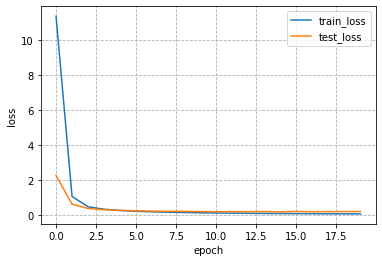

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_losses, label="train_loss")
fig_plot.plot(test_losses, label="test_loss")
fig_plot.legend(loc="upper right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("loss")
fig_plot.grid(linestyle="--")
fig.savefig("losses_plot.png")
fig.show()

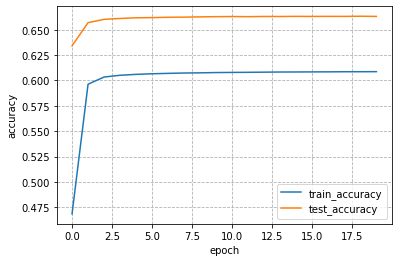

In [17]:
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_accuracyVec, label="train_accuracy")
fig_plot.plot(test_accuracyVec, label="test_accuracy")
fig_plot.legend(loc="lower right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("accuracy")
fig_plot.grid(linestyle="--")
fig.savefig("accuracy_plot.png")